In [4]:
import numpy as np

In [52]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from cmap import Colormap

In [57]:
def rosenbrock_vectorised(x):
    term1 = x[..., 1:] - x[..., :-1]**2
    term2 = 1 - x[..., :-1]
    return np.sum(100 * term1**2 + term2**2, axis=-1)

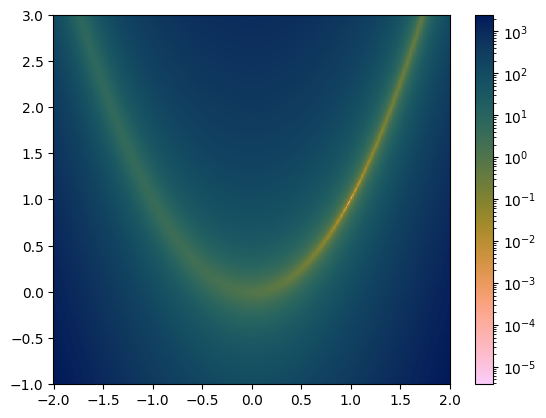

In [58]:
resolution = 512
X, Y = np.meshgrid(np.linspace(-2, 2, resolution), np.linspace(-1, 3, resolution))
X_vec = np.stack((X, Y), axis=-1)
fX = rosenbrock_vectorised(X_vec)

fig, ax = plt.subplots()

cmap = cmap=Colormap("crameri:batlow_r").to_mpl()
im = plt.pcolor(X, Y, fX, norm=colors.LogNorm(), cmap=cmap)
fig.colorbar(im)

In [62]:
def rosenbrock(x):
    term1 = x[1:] - x[:-1]**2
    term2 = 1 - x[:-1]
    return np.sum(100 * term1**2 + term2**2)

In [82]:
def grad_rosenbrock(x):
    n = len(x)
    grad = np.zeros_like(x, dtype=float)

    grad[0] = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    for k in range(1, n - 1):
        contrib_from_current_term = -400 * x[k] * (x[k+1] - x[k]**2) - 2 * (1 - x[k])
        contrib_from_previous_term = 200 * (x[k] - x[k-1]**2)
        grad[k] = contrib_from_current_term + contrib_from_previous_term

    grad[n-1] = 200 * (x[n-1] - x[n-2]**2)

    return grad

In [90]:
def hess_rosenbrock(x):
    n = len(x)
    H = np.zeros((n, n), dtype=float)

    if n == 0:
        return H

    # H_00 and H_01
    H[0, 0] = 2 - 400 * x[1] + 1200 * x[0]**2
    H[0, 1] = -400 * x[0]
    H[1, 0] = -400 * x[0]
    
    # Intermediate rows/columns (1 to n-2)
    for j in range(1, n - 1):
        H[j, j-1] = -400 * x[j-1]
        H[j-1, j] = -400 * x[j-1] # Symmetric
        
        H[j, j] = 2 - 400 * x[j+1] + 1200 * x[j]**2 + 200
        
        H[j, j+1] = -400 * x[j]
        H[j+1, j] = -400 * x[j] # Symmetric

    # H_n-1,n-1 and H_n-1,n-2
    H[n-1, n-1] = 200
    H[n-1, n-2] = -400 * x[n-2]
    H[n-2, n-1] = -400 * x[n-2] # Symmetric

    return H

In [100]:
def RandNysApprox(Y, Q, rj):
    B = Y.T @ Y
    U_B, Sigma_B_vals, V_B_T = np.linalg.svd(B)
    V_nystrom = Q @ U_B 
    Lambda_hat = np.diag(Sigma_B_vals) 
    
    return V_nystrom, Lambda_hat

In [107]:
def sketchy_SGC(x0, m=50, bg=2, u=5, rj=1):
    p = len(x0)
    
    wk = x0.copy()
    
    for k in range(m):
        Bk = np.random.choice(np.arange(p), size=bg, replace=False)
        
        gradf = grad_rosenbrock(wk)
        gBk = np.zeros_like(wk)
        for idx in Bk:
            gBk[idx] = gradf[idx]
            
        if k % u == 0:
            Sj = np.random.choice(np.arange(p), size=bg, replace=False)
            Phi = np.random.normal(size=(p, rj))
            Q = np.linalg.qr(Phi, mode='economic')
            
            full_Hwk = hess_rosenbrock(wk)
            H_Sjwk = np.zeros_like(full_Hwk)
            for row_idx in Sj:
                H_Sjwk[row_idx, :] = full_Hwk[row_idx, :]
            Y = H_Sjwk @ Q
            
            V_precon, Lambda_hat_precon = RandNysApprox(Y, Q, rj)

In [108]:
sketchy_SGC(
    x0=np.array([0, 0, 0, 0])
)

C:\Users\joe\AppData\Local\Temp\ipykernel_47124\2966876431.py:17: DeprecationWarning: The 'economic' option is deprecated.
  Q = np.linalg.qr(Phi, mode='economic')
